# 1. Khởi tạo và import các thư viện cần thiết

In [1]:
%load_ext tensorboard

In [2]:
!pip install tensorflow matplotlib quickdraw tensorflow-datasets


In [3]:
import datetime, os
import tensorflow as tf

from pathlib import Path
from matplotlib import pyplot as plt
from quickdraw import QuickDrawDataGroup, QuickDrawData

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import sparse_categorical_accuracy
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard

# 2. Load ảnh từ dataset của google, chỉ chọn ảnh đã recognized bởi google

In [4]:
image_size = (28, 28)

In [5]:
print(QuickDrawData().drawing_names)

['aircraft carrier', 'airplane', 'alarm clock', 'ambulance', 'angel', 'animal migration', 'ant', 'anvil', 'apple', 'arm', 'asparagus', 'axe', 'backpack', 'banana', 'bandage', 'barn', 'baseball bat', 'baseball', 'basket', 'basketball', 'bat', 'bathtub', 'beach', 'bear', 'beard', 'bed', 'bee', 'belt', 'bench', 'bicycle', 'binoculars', 'bird', 'birthday cake', 'blackberry', 'blueberry', 'book', 'boomerang', 'bottlecap', 'bowtie', 'bracelet', 'brain', 'bread', 'bridge', 'broccoli', 'broom', 'bucket', 'bulldozer', 'bus', 'bush', 'butterfly', 'cactus', 'cake', 'calculator', 'calendar', 'camel', 'camera', 'camouflage', 'campfire', 'candle', 'cannon', 'canoe', 'car', 'carrot', 'castle', 'cat', 'ceiling fan', 'cell phone', 'cello', 'chair', 'chandelier', 'church', 'circle', 'clarinet', 'clock', 'cloud', 'coffee cup', 'compass', 'computer', 'cookie', 'cooler', 'couch', 'cow', 'crab', 'crayon', 'crocodile', 'crown', 'cruise ship', 'cup', 'diamond', 'dishwasher', 'diving board', 'dog', 'dolphin', 

In [ ]:
def generate_class_images(name, max_drawings, recognized):
    directory = Path("dataset/" + name)

    if not directory.exists():
        directory.mkdir(parents=True)

    images = QuickDrawDataGroup(name, max_drawings=max_drawings, recognized=recognized)
    for img in images.drawings:
        filename = directory.as_posix() + "/" + str(img.key_id) + ".png"
        img.get_image(stroke_width=3).resize(image_size).save(filename)

# ở đây lấy toàn bộ 345 categoories nên chỉ lấy 1200 ảnh, có thể chỉ chọn 2-4 categories như yêu cầu và tăng số lượng max drawing để train chính xác hơn cho những categories đó
# có thể dùng block code ở trên để in ra mảng categories và chọn từ đó, ví dụ như ['aircraft carrier', 'airplane', 'alarm clock']

for label in QuickDrawData().drawing_names:
    generate_class_images(label, max_drawings=1200, recognized=True)

loading aircraft carrier drawings
load complete
loading airplane drawings
load complete
loading alarm clock drawings
load complete
loading ambulance drawings
load complete
loading angel drawings
load complete
loading animal migration drawings
load complete
loading ant drawings
load complete
loading anvil drawings
load complete
loading apple drawings
load complete
loading arm drawings
load complete
loading asparagus drawings
load complete
loading axe drawings
load complete
loading backpack drawings
load complete
loading banana drawings
load complete
loading bandage drawings
load complete
loading barn drawings
load complete
loading baseball bat drawings
load complete
loading baseball drawings
load complete
loading basket drawings
load complete
loading basketball drawings
load complete
loading bat drawings
load complete
loading bathtub drawings
load complete
loading beach drawings
load complete
loading bear drawings
load complete
loading beard drawings
load complete
loading bed drawings
l

# 3. tạo hai tập dữ liệu ảnh: một cho huấn luyện và một cho validation

In [ ]:
batch_size = 32

train_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=123,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=123,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

Found 414000 files belonging to 345 classes.
Using 331200 files for training.
Found 414000 files belonging to 345 classes.
Using 82800 files for validation.


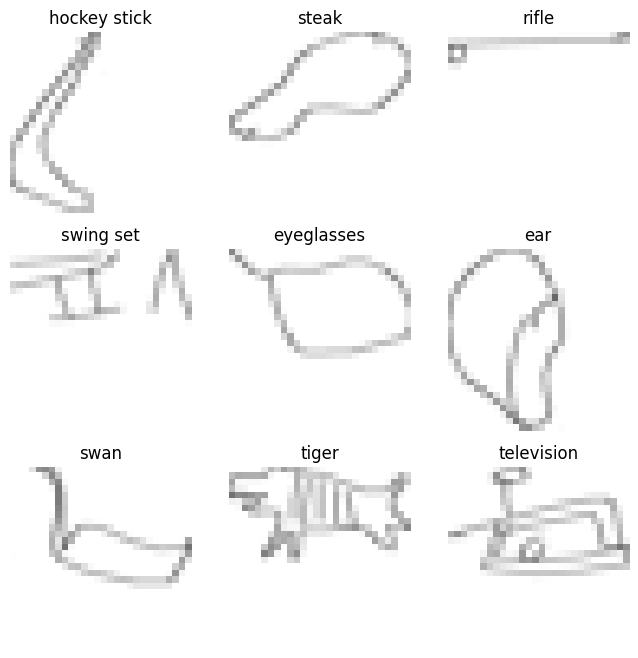

In [ ]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        data = images[i].numpy().astype("uint8")
        plt.imshow(data, cmap='gray', vmin=0, vmax=255)
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

# 4. tạo một mô hình mạng nơ-ron tích chập (CNN - Convolutional Neural Network)

In [ ]:
input_shape = (28, 28, 1)
n_classes = 345

model = Sequential([
    Rescaling(1. / 255, input_shape=input_shape),
    BatchNormalization(),

    Conv2D(6, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(8, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(10, kernel_size=(3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(700, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(500, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(400, activation='relu'),
    Dropout(0.2),

    Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer="adam",
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 batch_normalization (Batch  (None, 28, 28, 1)         4         
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         60        
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 8)         440       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 10)        730       
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 10)        40        
 chNormalization)                                       

# 5.huấn luyện model

In [ ]:
epochs = 6 # nên từ 5->10 để tránh train quá lâu và bị nguy cơ Overfitting

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback]
)

model.save('./models/model_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

Epoch 1/6
10350/10350 [==============================] - 917s 89ms/step - loss: 2.6002 - accuracy: 0.3758 - val_loss: 2.1840 - val_accuracy: 0.4538
Epoch 2/6
10350/10350 [==============================] - 915s 88ms/step - loss: 2.1099 - accuracy: 0.4684 - val_loss: 1.7385 - val_accuracy: 0.5483
Epoch 3/6
10350/10350 [==============================] - 919s 89ms/step - loss: 1.8899 - accuracy: 0.5135 - val_loss: 1.7812 - val_accuracy: 0.5410
Epoch 4/6
10350/10350 [==============================] - 929s 90ms/step - loss: 1.7645 - accuracy: 0.5402 - val_loss: 1.7846 - val_accuracy: 0.5420
Epoch 5/6
10350/10350 [==============================] - 903s 87ms/step - loss: 1.6788 - accuracy: 0.5584 - val_loss: 1.5993 - val_accuracy: 0.5836
Epoch 6/6
10350/10350 [==============================] - 930s 90ms/step - loss: 1.6062 - accuracy: 0.5737 - val_loss: 1.5238 - val_accuracy: 0.6005


# 6. chuyển đổi một mô hình TensorFlow đã lưu sang định dạng TensorFlow Lite (TFLite) để nhúng vào web

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("models/model_20220220-184035") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
%tensorboard --logdir logs